In [1]:
using CSV, DataFrames
using LinearAlgebra
using PyPlot
using Test
using Printf
using Statistics
import PyPlot; const plt = PyPlot

PyPlot

In [2]:
#Read in MOFs

_df_henry = CSV.read("../data/new_henry_constants.csv")
for (i, xtal) in enumerate(_df_henry[:crystal])
    _df_henry[i, :crystal] = split(_df_henry[i, :crystal], "_")[1]
end
dropmissing!(_df_henry)
global const df_henry = deepcopy(_df_henry)

,crystal,CO2_henry coefficient [mmol/(g-bar)],CO2_err henry coefficient [mmol/(g-bar)],CO2_Qst (kJ/mol),CO2_elapsed time (min),C2H6_henry coefficient [mmol/(g-bar)],C2H6_err henry coefficient [mmol/(g-bar)],C2H6_Qst (kJ/mol),C2H6_elapsed time (min),CH4_henry coefficient [mmol/(g-bar)],CH4_err henry coefficient [mmol/(g-bar)],CH4_Qst (kJ/mol),CH4_elapsed time (min)
1,ANUGIA,2.63742,0.0590755,18.2735,88.4244,6.51231,0.0887694,19.7513,1.44775,0.901775,0.00437934,12.6288,0.510682
2,BIMDEF,65.7304,2.45672,34.5719,27.2218,242.899,20.2111,39.2799,0.43965,5.28078,0.166393,24.7754,0.284099
3,CAXVII,8.36614,0.455366,28.0462,57.157,4.80993,0.0385976,20.6839,0.491749,0.585257,0.00530674,13.8298,0.391735
4,COF-103,1.8747,0.00323189,13.9922,198.454,4.67993,0.0103793,15.7725,3.6132,0.957084,0.00124375,10.7641,1.62929
5,COF-105,1.20756,0.00280427,10.8014,2416.47,1.84972,0.00291044,11.7479,10.9051,0.704437,0.000240075,7.59191,3.80418
6,COF-108,1.4301,0.0138768,12.0168,50.0367,2.42885,0.023418,13.6363,1.68901,0.781522,0.000952797,8.21046,0.794621
7,FIQCEN,6.25527,0.206608,25.4471,55.2366,77.7621,5.45295,36.4557,0.877329,1.91465,0.0256049,20.8594,0.476047
8,HOGLEV,10.0094,0.250294,28.2896,1232.95,22.2095,0.224581,27.8543,4.11773,1.4672,0.00402191,17.3421,3.04576
9,KAMZUV,1.44936,0.0594285,20.1797,152.322,5.00998,0.107121,21.8849,0.949748,0.603727,0.00930121,14.9573,0.705137
10,KAXQIL,125.793,6.33335,36.2569,93.334,12506.2,613.074,49.9651,1.10389,39.1743,1.2566,31.608,0.931378


In [3]:
function perform_svd(gas1::AbstractString, gas2::AbstractString)
    #Should we create the program for comparing just two MOFs?
    #Or should it be able to compare 3 as well?

    # MOFs[1] indicates the length of the first column, eg. the number of MOFs being screened
    #initialize Henry's Matrix
    N = size(df_henry)[1]
    sigma = zeros(N, N, 2)

    for i = 1:N
        for j = i+1:N
            H = make_h_matrix(i, j, gas1, gas2)
            F = svd(H)
            sigma[i, j, :] = F.S
        end
    end
    return sigma
end

perform_svd (generic function with 1 method)

In [4]:
function make_h_matrix(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof2, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof2, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix (generic function with 1 method)

In [5]:
function analyze_svd(sigma::Array{Float64, 3})

    #initialize some arrays
    best_indices = argmax(sigma[:, :, 2]) # finds the largest σ₂ value
    worst_indices = argmin(sigma[:, :, 1]) # finds the smallest σ₁ value

    MOF1 = String(df_henry[best_indices[1], :crystal])
    MOF2 = String(df_henry[best_indices[2], :crystal])

    println("The most sensitive pair of MOFs is " * MOF1 * " and " * MOF2)

    MOF3 = String(df_henry[worst_indices[1], :crystal])
    MOF4 = String(df_henry[worst_indices[2], :crystal])

    println("The least sensitive pair of MOFs is " * MOF3 * " and " * MOF4)

    #error analysis?
    #Delta K/H?

#=
    #create circle array
    n = 1000
    #TODO change to range
    x_lin = linspace(-1,1,n)
    y = zeros(2*n)
    x = zeros(2*n)
    for i = 1:n
        y[2 * i] = sqrt(1 - (x_lin[i] ^ 2))
        y[2 * i - 1] = - sqrt(1 - (x_lin[i] ^ 2))
        x[2 * i] = x_lin[i]
        x[2 * i - 1] = x_lin[i]
    end

    xx = x
    yy = y

    pre_plot = plot(x = xx, y = yy, Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    #formats the xy coords appropriately
    xy = hcat(x, y)
    xy = transpose(xy)

    #stretches the xy coords by the sigma from the svd
    highest_sigma = sigma[highest_index[1], highest_index[2]]
    sigma = [highest_sigma[1] 0; 0 highest_sigma[2]]
    println(sigma)
    xy_stretched = sigma*xy

    post_plot = plot(x = xy_stretched[1,:], y = xy_stretched[2,:], Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    return post_plot
    =#
end

analyze_svd (generic function with 1 method)

In [6]:
function mof2index(mof::AbstractString)
    boolarray = mof .== df_henry[:crystal]
    if sum(boolarray) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(boolarray) == 0
        @error "No MOF matched the given MOF name"
    end
    return argmax(boolarray)
end

mof2index (generic function with 1 method)

In [7]:
@testset "MOF to index test" begin
    @test isapprox(mof2index("COF-103"), 4)
end

Test Summary:     | Pass  Total
MOF to index test |    1      1


Test.DefaultTestSet("MOF to index test", Any[], 1, false)

In [8]:
function plot_graphs(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = make_h_matrix(mof1, mof2, gas1, gas2)
    F = svd(H)
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    n = H * p # required input

    S = perform_svd(gas1, gas2)
    biggest_σ = maximum(S[:, :, 1])

    function plot_vector(x; head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        arrow(0, 0, x_plot[1], x_plot[2], head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        text(x_label[1], x_label[2], label)
    end

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=2 * π)

    m = plt.cm[:ScalarMappable](norm=cnorm, cmap=plt.cm[:hsv])
    m[:set_array]([]) # trick


    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    for i = 1:length(θ)-1
        plt.plot(p[1, i:i+1], p[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    for k = 1:2
        plot_vector(F.V[:, k], color="k",
            label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    end
    title("Composition Space")
    tight_layout()

    subplot(122, aspect="equal")
    ylim([-biggest_σ, biggest_σ])
    xlim([-biggest_σ, biggest_σ])
    for i = 1:length(θ)-1
        plt.plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k], head_length=0.005,
            head_width=0.05/3, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.025)
    end
    axis("equal")
    xlabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof1))
    ylabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof2))
    title("Response Space")
    tight_layout()
    savefig(@sprintf("composition_response_of_%i_and_%i.png", mof1, mof2), format="png", dpi=300)
end

plot_graphs(mof1::AbstractString, mof2::AbstractString, gas1::AbstractString, gas2::AbstractString) = plot_graphs(mof2index(mof1), mof2index(mof2), gas1, gas2)

plot_graphs (generic function with 2 methods)

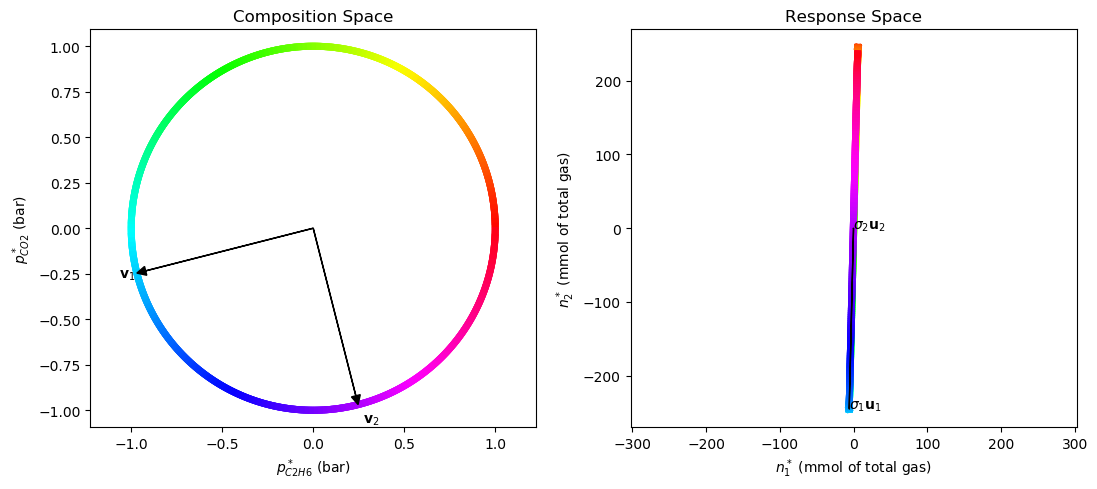

In [9]:
plot_graphs(1, 2, "C2H6", "CO2")

In [10]:
sigma = perform_svd("C2H6", "CO2")
analyze_svd(sigma)

The most sensitive pair of MOFs is KAXQIL and VEBHUG
The least sensitive pair of MOFs is ANUGIA and ANUGIA


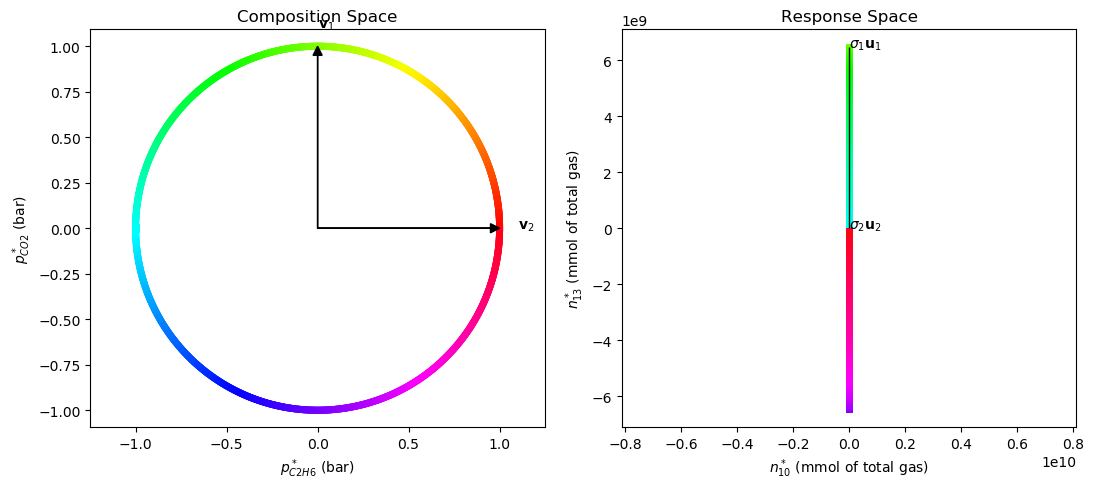

In [12]:
plot_graphs("KAXQIL", "VEBHUG", "C2H6", "CO2")

In [11]:

@testset "Sensor Tests" begin
    H = make_h_matrix(3, 5, "CO2", "C2H6")
    G = [(8.91e-5) (4.84e-5); (1.87e-5) (4.68e-5)] .- [5.84e-6; 9.56e-6]
    @test isapprox(H, G)
end

Sensor Tests: Test Failed at In[11]:5
  Expression: isapprox(H, G)
   Evaluated: isapprox([7.78088 4.22468; 0.503122 1.14528], [8.326e-5 4.256e-5; 9.14e-6 3.724e-5])
Stacktrace:
 [1] macro expansion at .\In[11]:5 [inlined]
 [2] macro expansion at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.0\Test\src\Test.jl:1083 [inlined]
 [3] top-level scope at .\In[11]:3
Test Summary: | Fail  Total
Sensor Tests  |    1      1


TestSetException: Some tests did not pass: 0 passed, 1 failed, 0 errored, 0 broken.